In [28]:
from keras.models import Sequential, load_model
import pandas as pd
import numpy as np
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import random
import datetime

from Indicator import Indicator

def check_trend(df):
    df.loc[(df['Close'] > df['MA']) &
    ((df['Close'] > df['Close'].shift(1)) | (df['MA'] > df['MA'].shift(1))) &
    ((df['Close'] > df['Close'].shift(2)) | (df['MA'] > df['MA'].shift(2))) &
    ((df['Close'] > df['Close'].shift(3)) | (df['MA'] > df['MA'].shift(3))) &
    ((df['Close'] > df['Close'].shift(4)) | (df['MA'] > df['MA'].shift(4))) &
    ((df['Close'] > df['Close'].shift(5)) | (df['MA'] > df['MA'].shift(5))) , 'Trend'] = 'Up'

    df.loc[(df['Close'] < df['MA']) &
    ((df['Close'] < df['Close'].shift(1)) | (df['MA'] < df['MA'].shift(1))) &
    ((df['Close'] < df['Close'].shift(2)) | (df['MA'] < df['MA'].shift(2))) &
    ((df['Close'] < df['Close'].shift(3)) | (df['MA'] < df['MA'].shift(3))) &
    ((df['Close'] < df['Close'].shift(4)) | (df['MA'] < df['MA'].shift(4))) &
    ((df['Close'] < df['Close'].shift(5)) | (df['MA'] < df['MA'].shift(5))) , 'Trend'] = 'Down'
    
    df.loc[df['Trend'].isnull(), 'Ntrend'] = df['Trend'].shift(1)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull(),'Ntrend'] = df['Trend'].shift(2)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull(),'Ntrend'] = df['Trend'].shift(3)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull() & 
    df['Trend'].shift(3).isnull(),'Ntrend'] = df['Trend'].shift(4)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull() & 
    df['Trend'].shift(3).isnull() & df['Trend'].shift(4).isnull(),'Ntrend'] = df['Trend'].shift(5)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull() & 
    df['Trend'].shift(3).isnull() & df['Trend'].shift(4).isnull() & df['Trend'].shift(5).isnull(),'Ntrend'] = df['Trend'].shift(6)
    
    df['S1'] = df['Close'].shift(-1)
    df['S2'] = df['Close'].shift(-2)
    df.loc[df['S1'].isnull(),'S1'] = 0
    df.loc[df['S2'].isnull(),'S2'] = 0

   
    #Trading Signal (0,1)
    df.loc[(df['Trend'] == 'Up') | (df['Ntrend'] == 'Up'), 'Trading Signal'] = ((abs(df['Close'] - df[['Close','S1','S2']].min(axis = 1)) / 
    abs(df[['Close','S1','S2']].max(axis = 1) - df[['Close','S1','S2']].min(axis = 1)))*0.5) + 0.5
    df.loc[(df['Trend'] == 'Down') | (df['Ntrend'] == 'Down'), 'Trading Signal'] = ((abs(df['Close'] - df[['Close','S1','S2']].min(axis = 1)) / 
    abs(df[['Close','S1','S2']].max(axis = 1) - df[['Close','S1','S2']].min(axis = 1)))*0.5)
   
    df.loc[df['Trend'].isnull(),'Trend'] =df['Ntrend']
    
    df = df.drop(['Ntrend','S1','S2'],axis=1)
        
    return df

def fillindicator(df):
    indicator = Indicator()
    train_set = indicator.MA(df,15)
    train_set = indicator.MACD(df)
    train_set = indicator.STOCHASTIC(df)
    train_set = indicator.RSI(df)
    train_set = indicator.WILLIAMSR(df)
    return train_set

def norm(df,col_name):# this will get columnname + _n
    #Normalize data each colunm in to range -1 to 1
    df[col_name+'_n'] = (df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())
    return df

def signal_to_num(df):
    df.loc[df['Trend']=='Down','Trend'] = 0
    df.loc[df['Trend']=='Up','Trend'] = 1
    return df

In [30]:
start = datetime.datetime(2019,1,1)#26 day before start year for make indicator
end = datetime.datetime(2021,1,1)
stock = 'AES'
df = web.DataReader(stock,'yahoo',start,end)
df = fillindicator(df)
df = norm(df,'MA')
df = norm(df,'MACD')
df = norm(df,'SIGNAL LINE')
df = norm(df,'%K')
df = norm(df,'%D')
df = norm(df,'%R')
df = norm(df,'RSI-7')
df = norm(df,'RSI-14')
df = check_trend(df)
df = df.iloc[61:]
df = signal_to_num(df)

In [31]:
model = load_model('Model/best_5.h5')

In [32]:
test_x = df[['MA_n','MACD_n','SIGNAL LINE_n','RSI-7_n','%K_n','%D_n','%R_n','Trading Signal','Trend']]
x_test = test_x[['MA_n','MACD_n','SIGNAL LINE_n','RSI-7_n','%K_n','%D_n','%R_n','Trading Signal']].values
y_test = test_x['Trend'].values
x_test=np.asarray(x_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

In [33]:
pred = model.predict(x_test)

In [34]:
data = df
data['pred'] = pred
mean = data['pred'].mean()
data['pred'] =np.where(data['pred'] >= mean,'up','down')

data['up'] = np.where(data['pred']=='up',data['Close'],None)
data['down'] = np.where(data['pred']=='down',data['Close'],None)

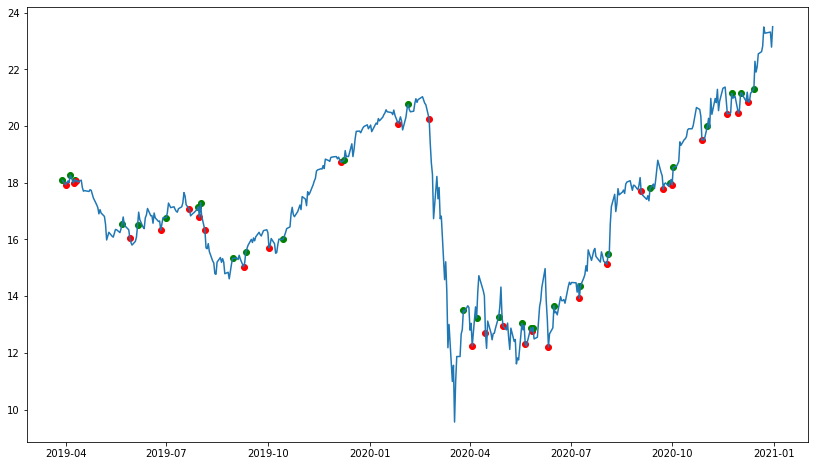

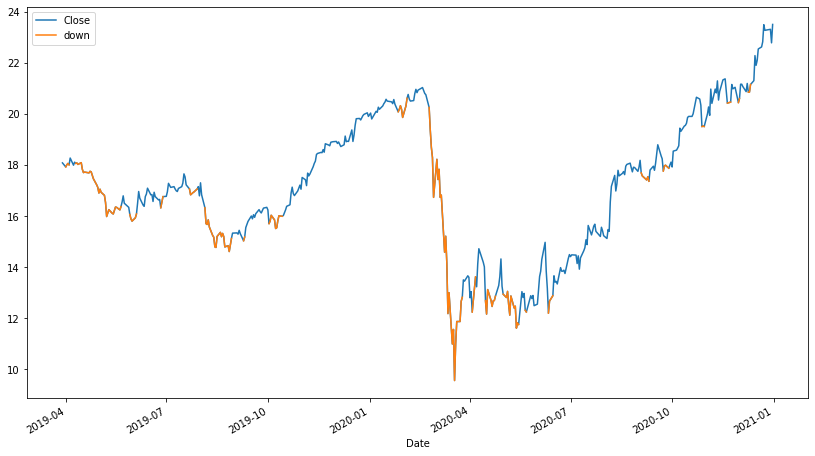

In [35]:
plt.figure(figsize=(14,8))
plt.plot(data.index,data['Close'])
b = []
s = []
flag = 'sell'
for i,r in data.iterrows():
    if (flag=='sell') & (r['pred']=='up'):
        plt.scatter(x=i, y=r['Close'], c='green')
        b.append(r['Close'])
        flag = 'buy'
    elif (flag=='buy') & (r['pred']=='down'):
        plt.scatter(x=i, y=r['Close'], c='red')
        s.append(r['Close'])
        flag = 'sell'

data[['Close','down']].plot(figsize=(14,8))
plt.show()

In [9]:
if len(b)>len(s):
    del b[-1]

In [10]:
sum(np.array(s)-np.array(b))

28.0

In [11]:
for i in range(len(b)):
    print(b[i],s[i])

36.25 38.75
27.5 31.25
32.75 32.5
33.75 37.0
38.0 37.5
31.25 30.75
31.75 30.25
30.5 30.25
31.0 31.0
31.0 30.25
31.0 34.0
34.0 37.75
37.75 38.75
38.75 44.5
44.5 53.25
